In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.ndimage import label
from tqdm import tqdm

# Configuration
DIM = 3
POWER = 3
MAX_STEPS = POWER + 5

def generate_percolation_lattice(size, p):
    return np.random.choice([0, 1], (size, size), p=[1-p, p]).astype(np.uint8)

def check_percolation(lattice):
    labeled, _ = label(lattice)
    top = set(labeled[0]) - {0}
    bottom = set(labeled[-1]) - {0}
    left = set(labeled[:,0]) - {0}
    right = set(labeled[:,-1]) - {0}
    return float(bool(top & bottom) or bool(left & right))

def first_coarse_graining(binary_lattice, dim):
    """Average non-overlapping dim×dim blocks."""
    t = torch.tensor(binary_lattice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    patches = F.unfold(t, kernel_size=dim, stride=dim)             # [1, dim*dim, num_patches]
    patches = patches.permute(0, 2, 1)                             # [1, num_patches, dim*dim]
    coarse_vals = patches.mean(dim=2)                             # [1, num_patches]
    H, W = binary_lattice.shape
    new_h, new_w = H // dim, W // dim
    return coarse_vals.view(1, 1, new_h, new_w).squeeze(0)        # [1, new_h, new_w]

class PercolationModel(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.rule = nn.Sequential(
            nn.Linear(dim * dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, max_steps=MAX_STEPS):
        b, c, H, W = x.shape
        for _ in range(max_steps):
            if H < self.dim or W < self.dim:
                break
            patches = F.unfold(x, kernel_size=self.dim, stride=self.dim)  # [b, dim*dim, np]
            patches = patches.permute(0, 2, 1).contiguous()               # [b, np, dim*dim]
            out = self.rule(patches.view(-1, self.dim*self.dim))          # [b*np, 1]
            new_h, new_w = H // self.dim, W // self.dim
            x = out.view(b, 1, new_h, new_w)
            _, _, H, W = x.shape
        return x.squeeze(1).view(b, -1)  # returns shape [b, new_h*new_w] or [b] if fully reduced

def prepare_dataset(N, size):
    data = []
    for _ in tqdm(range(N), desc="Generating data"):
        p = np.random.uniform(0.1, 0.9)
        L = generate_percolation_lattice(size, p)
        data.append((L, check_percolation(L)))
    return data

def train_epoch(model, device, data, batch_size, opt, crit):
    model.train()
    total_loss = 0.0
    for i in tqdm(range(0, len(data), batch_size), desc="Training"):
        batch = data[i:i+batch_size]
        lattices = [first_coarse_graining(x, DIM) for x, _ in batch]  # list of [1,H',W']
        inputs = torch.stack(lattices).to(device)                     # [B,1,H',W']
        targets = torch.tensor([y for _, y in batch], dtype=torch.float32, device=device)
        
        opt.zero_grad()
        outputs = model(inputs)                                       # [B] or [B,1]
        loss = crit(outputs.view(-1), targets)
        loss.backward()
        opt.step()
        total_loss += loss.item() * len(batch)
    return total_loss / len(data)


In [2]:
# ----------------- Run -----------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SIZE = DIM ** POWER
train_data = prepare_dataset(5_000, SIZE)

model = PercolationModel(DIM).to(DEVICE)
opt   = optim.Adam(model.parameters(), lr=1e-3)
crit  = nn.BCELoss()

for epoch in range(1, 6):
    loss = train_epoch(model, DEVICE, train_data, 10, opt, crit)
    print(f"Epoch {epoch} — Loss: {loss:.4f}")

Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 488.66it/s]


Epoch 1 — Loss: 0.3357


Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 448.45it/s]


Epoch 2 — Loss: 0.0993


Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 409.73it/s]


Epoch 3 — Loss: 0.0914


Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 467.23it/s]


Epoch 4 — Loss: 0.0899


Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 488.25it/s]


Epoch 5 — Loss: 0.0892


In [3]:
# Full testing
def test_extensive_systems(model, dim, power, device='cpu', num_tests=10,
                          system_size='standard', p_range=(0, 1), verbose=True):
    """
    Tests model on raw lattices without initial coarse-graining
    Args:
        system_size: 'smaller' (dim^(power-1)), 'standard' (dim^power), or 'larger' (dim^(power+1))
    """
    model.eval()
    
    # Calculate lattice size
    size_power = {
        'smaller': power - 1,
        'standard': power,
        'larger': power + 1
    }[system_size]
    
    lattice_size = dim ** size_power
    results = []
    
    for _ in tqdm(range(num_tests), desc=f"Testing {lattice_size}x{lattice_size}"):
        # Generate raw lattice
        p = np.random.uniform(*p_range)
        lattice = generate_percolation_lattice(lattice_size, p)
        true_label = check_percolation(lattice)
        
        # Directly convert to tensor (no coarse-graining)
        input_tensor = torch.tensor(lattice, dtype=torch.float32)
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0).to(device)  # [1,1,H,W]
        
        with torch.no_grad():
            pred = model(input_tensor).item()
        
        results.append((lattice, true_label, pred))
    
    # Calculate metrics
    threshold = 0.5
    correct = sum(1 for _, lbl, pred in results if (pred > threshold) == lbl)
    acc = correct / num_tests
    
    if verbose:
        print(f"\n{lattice_size}x{lattice_size} Results:")
        print(f"Accuracy: {acc:.2%}")
        print(f"Avg prediction | Perc: {np.mean([p for _,l,p in results if l==1]):.3f}")
        print(f"Avg prediction | Non-Perc: {np.mean([p for _,l,p in results if l==0]):.3f}")
    
    return results

# Test configurations
test_configs = [
    {'system_size': 'smaller', 'num_tests': 100, 'p_range': (0, 1)},
    {'system_size': 'standard', 'num_tests': 100, 'p_range': (0, 1)},
    {'system_size': 'larger', 'num_tests': 100, 'p_range': (0, 1)},
    {'system_size': 'standard', 'num_tests': 200, 'p_range': (0.58, 0.61)}
]

# Unified test execution
test_results = {}
for config in test_configs:
    key = f"{config['system_size']}_{config['p_range'][0]}-{config['p_range'][1]}"
    test_results[key] = test_extensive_systems(
        model=model,
        dim=DIM,
        power=POWER,
        device=DEVICE,
        **config
    )


# 1. Compute summary statistics for each config
summaries = {}
for key, results in test_results.items():
    # results is a list of (lattice, true_label, pred) tuples
    acc = sum((pred > 0.5) == lbl for _, lbl, pred in results) / len(results)
    mean_perc     = np.mean([pred for _, lbl, pred in results if lbl == 1]) if any(lbl==1 for _,lbl,_ in results) else float('nan')
    mean_non_perc = np.mean([pred for _, lbl, pred in results if lbl == 0]) if any(lbl==0 for _,lbl,_ in results) else float('nan')
    summaries[key] = (acc, mean_perc, mean_non_perc)

# 2. Write to file
filename = f'Accuracy_{DIM}x{DIM}_via_AFS.txt'
with open(filename, 'w', encoding = 'utf-8') as f:
    f.write(f'PercolationModel {DIM}×{DIM} results via AFS\n')
    f.write('='*40 + '\n\n')
    for key, (acc, mp, mnp) in summaries.items():
        f.write(f'Config: {key}\n')
        f.write(f'  -> Accuracy       : {acc:.2%}\n')
        f.write(f'  -> Avg if perc    : {mp:.3f}\n')
        f.write(f'  -> Avg if non-perc: {mnp:.3f}\n\n')

print(f"Saved test summary to {filename}")


Testing 9x9: 100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1796.78it/s]



9x9 Results:
Accuracy: 91.00%
Avg prediction | Perc: 0.846
Avg prediction | Non-Perc: 0.042


Testing 27x27: 100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1612.95it/s]



27x27 Results:
Accuracy: 6.00%
Avg prediction | Perc: 0.099
Avg prediction | Non-Perc: 0.955


Testing 81x81: 100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1023.29it/s]



81x81 Results:
Accuracy: 99.00%
Avg prediction | Perc: 0.984
Avg prediction | Non-Perc: 0.016


Testing 27x27: 100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1753.78it/s]


27x27 Results:
Accuracy: 29.50%
Avg prediction | Perc: 0.372
Avg prediction | Non-Perc: 0.632
Saved test summary to Accuracy_3x3_via_AFS.txt


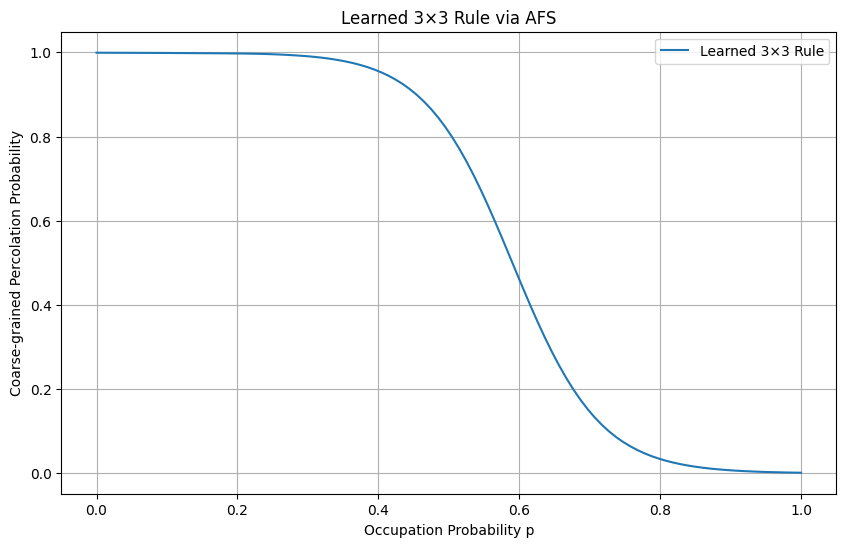

In [4]:
# Visualization

def visualize_rule(model, dim, device='cpu'):
    import matplotlib.pyplot as plt
    p_values = np.linspace(0, 1, 100)
    model.eval()
    rule_predictions = []

    with torch.no_grad():
        for p in p_values:
            # Use a full dim×dim block to query the learned rule
            input_block = torch.full((1, 1, dim, dim), p, device=device, dtype=torch.float32)
            pred = model(input_block).item()
            rule_predictions.append(pred)
    
    plt.figure(figsize=(10, 6))
    plt.plot(p_values, rule_predictions, label=f'Learned {dim}×{dim} Rule')
    plt.xlabel('Occupation Probability p')
    plt.ylabel('Coarse-grained Percolation Probability')
    plt.title(f'Learned {dim}×{dim} Rule via AFS')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'Learned_{dim}x{dim}_Rule_via_AFS.pdf')
    plt.show()

# Call it
visualize_rule(model, DIM, DEVICE)


In [5]:
# Sanity check: full lattice and empty lattice


# Create full and empty lattices
full_lattice = np.ones((SIZE//3, SIZE//3), dtype=np.uint8)
empty_lattice = np.zeros((SIZE//3, SIZE//3), dtype=np.uint8)

# Function to test and return raw model output
def test_lattice(lattice):
    t = first_coarse_graining(lattice, DIM).to(DEVICE).unsqueeze(0)  # shape: [1,1,H',W']
    model.eval()
    with torch.no_grad():
        return model(t).item()

# Run tests
full_output = test_lattice(full_lattice)
empty_output = test_lattice(empty_lattice)

print(f"Full lattice output:  {full_output:.4f}")
print(f"Empty lattice output: {empty_output:.4f}")



Full lattice output:  0.0015
Empty lattice output: 0.9992


In [6]:
# Force just 1 step of the learned rule:
def test_lattice_one_step(lattice):
    t = first_coarse_graining(lattice, DIM).to(DEVICE).unsqueeze(0)
    # max_steps=1 means only one unfold→rule→rebuild
    out = model(t, max_steps=1)  # returns [b, new_h*new_w]
    # since new_h*new_w > 1, take the MEAN of all outputs as a “global score”
    return out.mean().item()

print("One-step full lattice: ", test_lattice_one_step(full_lattice))
print("One-step empty lattice:", test_lattice_one_step(empty_lattice))


One-step full lattice:  0.0015431076753884554
One-step empty lattice: 0.9991866946220398


In [7]:
import numpy as np

# Probabilities to test near the extremes
ps = [0.01, 0.05, 0.1, 0.9, 0.95, 0.99]

def test_lattice(lattice, full_recursion=True):
    t = first_coarse_graining(lattice, DIM).to(DEVICE).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        if full_recursion:
            return model(t).item()
        else:
            out = model(t, max_steps=1)    # only one rule application
            return out.mean().item()       # global score

print(f"{'p':>6} | {'one‐step':>8} | {'full':>8}")
print("-" * 28)
for p in ps:
    L = np.random.choice([0,1], (SIZE, SIZE), p=[1-p, p]).astype(np.uint8)
    o1 = test_lattice(L, full_recursion=False)
    of = test_lattice(L, full_recursion=True)
    print(f"{p:>6.2f} | {o1:>8.4f} | {of:>8.4f}")


     p | one‐step |     full
----------------------------
  0.01 |   0.9991 |   0.0016
  0.05 |   0.9989 |   0.0016
  0.10 |   0.9985 |   0.0016
  0.90 |   0.0091 |   0.9991
  0.95 |   0.0027 |   0.9992
  0.99 |   0.0019 |   0.9992


In [8]:
import numpy as np

# Choose a fine grid of p ∈ [0.0, 1.0]
ps = np.linspace(0.0, 1.0, 21)   # 21 points: 0.0, 0.05, 0.1, …, 0.95, 1.0

def test_lattice(lattice, full_recursion=True):
    t = first_coarse_graining(lattice, DIM).to(DEVICE).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        if full_recursion:
            return model(t).item()
        else:
            out = model(t, max_steps=1)
            return out.mean().item()

results = []
for p in ps:
    # generate one lattice per p
    L = np.random.choice([0,1], (SIZE, SIZE), p=[1-p, p]).astype(np.uint8)
    o1 = test_lattice(L, full_recursion=False)
    of = test_lattice(L, full_recursion=True)
    results.append((p, o1, of))

# Print in a table
print(f"{'p':>5} | {'one-step':>8} | {'full(5)':>8} | {'flip?':>6}")
print("-"*37)
for p, o1, of in results:
    flip = ("YES" if (o1 < 0.5 and of > 0.5) or (o1 > 0.5 and of < 0.5) else " no")
    print(f"{p:5.2f} | {o1:8.4f} | {of:8.4f} | {flip:>6}")


    p | one-step |  full(5) |  flip?
-------------------------------------
 0.00 |   0.9992 |   0.0016 |    YES
 0.05 |   0.9989 |   0.0016 |    YES
 0.10 |   0.9985 |   0.0016 |    YES
 0.15 |   0.9981 |   0.0016 |    YES
 0.20 |   0.9973 |   0.0016 |    YES
 0.25 |   0.9956 |   0.0017 |    YES
 0.30 |   0.9886 |   0.0019 |    YES
 0.35 |   0.9770 |   0.0022 |    YES
 0.40 |   0.9539 |   0.0031 |    YES
 0.45 |   0.9106 |   0.0057 |    YES
 0.50 |   0.8392 |   0.0197 |    YES
 0.55 |   0.6392 |   0.3645 |    YES
 0.60 |   0.5066 |   0.8268 |     no
 0.65 |   0.2710 |   0.9945 |    YES
 0.70 |   0.1721 |   0.9980 |    YES
 0.75 |   0.0880 |   0.9987 |    YES
 0.80 |   0.0409 |   0.9990 |    YES
 0.85 |   0.0188 |   0.9991 |    YES
 0.90 |   0.0057 |   0.9992 |    YES
 0.95 |   0.0045 |   0.9992 |    YES
 1.00 |   0.0015 |   0.9992 |    YES
